# DAGMM 適用例
- このサンプルでは、混合正規分布の異常スコアを算出します（人為的に2つの異常値を混ぜてあります）

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from dagmm import DAGMM

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## サンプルデータの生成
- 混合正規分布から乱数を生成します。
- ロジックの有効性を確認するために、異常値を2点混ぜておきます。

In [4]:
data, _ = make_blobs(n_samples=1000, n_features=5, centers=5, random_state=123)
data = StandardScaler().fit_transform(data)

In [5]:
data[300] = [-1, -1, -1, -1, -1]
data[500] = [ 1,  0,  1,  1,  1]
ano_index = [300, 500]

### 散布図
赤い点が「異常値」に当たります。

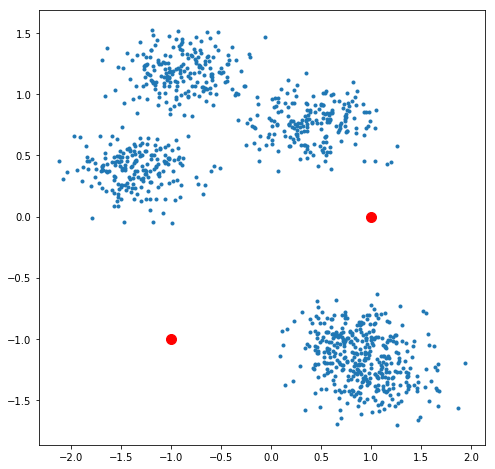

In [6]:
plt.figure(figsize=[8,8])
plt.plot(data[:,0], data[:,1], ".")
plt.plot(data[ano_index,0], data[ano_index,1], "o", c="r", markersize=10)

## DAGMMの利用

In [7]:
tf.reset_default_graph()

In [8]:
model_dagmm = DAGMM(
    comp_hiddens=[32,16,2], comp_activation=tf.nn.tanh,
    est_hiddens=[16,8], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=10000, minibatch_size=128
)

In [9]:
model_dagmm.fit(data)

 epoch 100/10000 : loss = 3.712
 epoch 200/10000 : loss = 2.976
 epoch 300/10000 : loss = 2.771
 epoch 400/10000 : loss = 2.692
 epoch 500/10000 : loss = 2.544
 epoch 600/10000 : loss = 2.352
 epoch 700/10000 : loss = 1.838
 epoch 800/10000 : loss = 1.660
 epoch 900/10000 : loss = 1.582
 epoch 1000/10000 : loss = 1.523
 epoch 1100/10000 : loss = 1.481
 epoch 1200/10000 : loss = 1.447
 epoch 1300/10000 : loss = 1.416
 epoch 1400/10000 : loss = 1.385
 epoch 1500/10000 : loss = 1.357
 epoch 1600/10000 : loss = 1.332
 epoch 1700/10000 : loss = 1.308
 epoch 1800/10000 : loss = 1.287
 epoch 1900/10000 : loss = 1.269
 epoch 2000/10000 : loss = 1.253
 epoch 2100/10000 : loss = 1.240
 epoch 2200/10000 : loss = 1.227
 epoch 2300/10000 : loss = 1.216
 epoch 2400/10000 : loss = 1.206
 epoch 2500/10000 : loss = 1.196
 epoch 2600/10000 : loss = 1.187
 epoch 2700/10000 : loss = 1.175
 epoch 2800/10000 : loss = 1.166
 epoch 2900/10000 : loss = 1.162
 epoch 3000/10000 : loss = 1.153
 epoch 3100/10000 :

In [10]:
energy = model_dagmm.predict(data)

Text(0,0.5,'Number of Sample(s)')

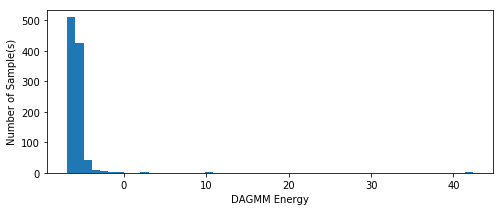

In [11]:
plt.figure(figsize=[8,3])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")

Text(0,0.5,'Energy')

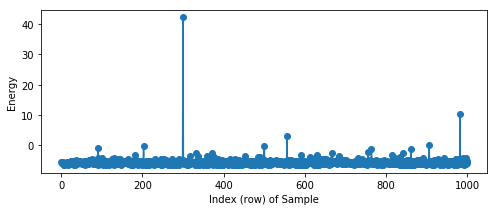

In [12]:
plt.figure(figsize=[8,3])
plt.plot(energy, "o-")
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")

### 対散布図プロット
- 計算されたサンプルごとのエネルギーの99%点を超えるデータを「異常値」とみなします。
    - 以下のプロットで、赤色の x 印としてあります。
- 人為的に混ぜた 2つの異常値は、正しく認識されています。

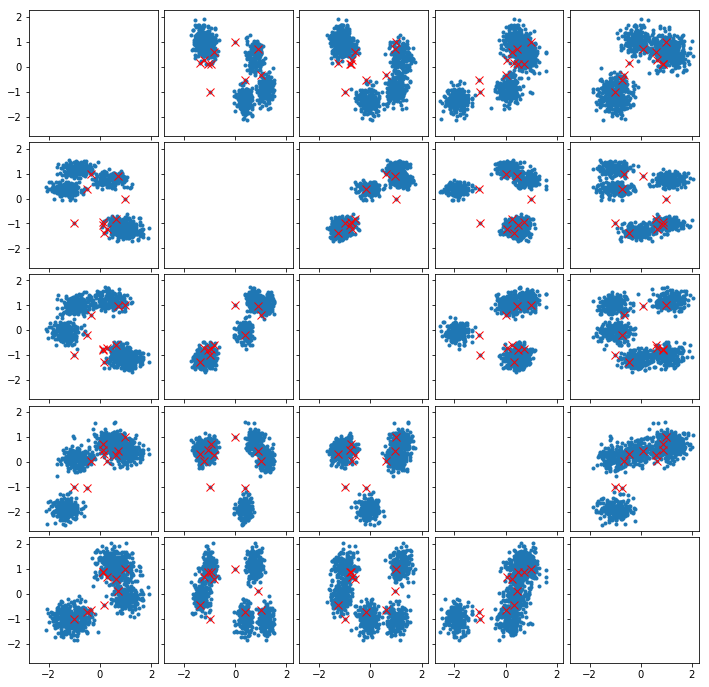

In [36]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[12,12], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[:,col], data[:,row], ".")
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 99)]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", markersize=8)